# Job Reassigment Problem en QAOA: Introduccion

This notebook aims to implement the QUBO formulation for Job Reassignment Problem (JRP), in order to try solve it using QAOA. 

El objetivo de este notebook es realizar la implementacion de la formulacion QUBO del Job Reassignment Problem (JRP), para posteriormente, intentar resolverlo utiliando el algoritmo de optimizacion cuantica aproximada (QAOA). Durante el notebook, se contrastara los resultados obtenidos contra otros algoritmos clásico de resolución. Seran probadas dos perspectivas diferentes en cuanto a la formulación QUBO. La primera, corresponde al diseño típico de un QUBO, es decir, una única funcion de costo que evalua a la instancia del problema por completo. La segunda, corresponde a una subproblemizacion del mismo, que sera explicada a detalle mas adelante. Hasta ahora, no se realizaron pruebas ni implementaciones de la subproblemizacion. Es un paso para mas adelante.

Este notebook tiene un fin introductorio, y no busca analizar instancias de JRP muy complejas ni tecnicas o parametros muy avanzados para el QAOA.

In [ ]:
pip install pydantic==1.10.13

In [1]:
from openqaoa import QUBO
from openqaoa.backends import create_device
from openqaoa import QAOA
from openqaoa.algorithms import QAOAResult

from qiskit import IBMQ

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer, GurobiOptimizer

### 1. Instancias de problema JRP

Here, the instance variables needed for the QUBO are defined. So as to simplify the understanding over the parameters, we define the following class diagram.

![SD](imgs/notebooks/JRPisntance_classDiagram.png)

The parameters are:

* priorities: each job has one. The smaller the value, the smaller the job priority.
* affinities: between each agent and job. las afinidades que puede tener cada agente con un trabajo en particular. The smaller the value, the smaller the affinity between a pair (agent,job).
* agents: the corresponding list.
* agents_assgJobs: relation 1to1. The job assigned to agent $\textit{i}$ in on the index $\textit{i}$ of the list.
* agents_assgJobsAfinnity: relation 1toM. On the index $\textit{i}$ it is found the affinity list for each of the agent, where the index $\textit{j}$ of this sublist shows the particular affinity for an assigned job $\textit{j}$.
* agents_vacnJobsAfinnity: relation 1toM. On the index $\textit{i}$ it is found the affinity listfor each of the eagent, where the index $\textit{j}$ of this sublist shows the particular affinity for a vancant job $\textit{j}$.
  
* assgJobs: the corresponding list
* assgJobs_agents: relation 1to1. The agent on the assigned job $\textit{i}$ in on the index $\textit{i}$ of the list. Inverse ist of agents_assgJobs.
* assgJobs_priority: relation 1a1. The priority of the assigned job $\textit{i}$ is found on the index $\textit{i}$ of the list.

* vacnJobs: the corresponding list.
* vacnJobs_priority: relation 1to1. The priority of the vacant job $\textit{i}$ is found on the index $\textit{i}$ of the list.

* priorityWeightCoeff: coefficient which affect how much affect the priorities on the final cost.
* affinityWeightCoeff: coefficient which affect how much affect the affinities on the final cost.

* penalty1 = penalty for the first constraint (read paper)
* penalty2 =  penalty for the second constraint (read paper)

* allBinaryVariable: all binary variables that will be coded. It is the product between the amount of agents and the amount of vacant jobs.

From the following instances cells, just run the one you would like to run with QAOA.

In [17]:
###INTANCE 1
### ESTA INSTANCIA NO TIENE CASOS DONDE CONVIENE CAMBIAR ( (vairables lineales con weight<0)), SU SOLUCION LOGICAMENTE ES UNA CADENA DE TODOS 0
### THIS INSTANCE DOESN'T HAS SITUATION WHERE IS RECOMMENDED TO CHANGE JOB (LINEAR VARS. WITH WEIGHT<0). LOGICALLY, THE SOLUTION IS AN ALL-0 BITSTRING.

#lower means more priority/affinity
priorities = [1,2,3,4,5]
affinities = [1,2,3,4,5]

agents = list(range(3))
agents_assgJobs = [2,1,0]

#each tuple is form by (agent_index,[affinities of each of the n jobs])
agents_assgJobsAfinnity = [
    [2,3,4]
    ,[5,4,3]
    ,[2,1,3]
]
agents_vacnJobsAfinnity = [
    [5,4,4,3]
    ,[3,2,1,1]
    ,[1,1,1,1]
]


assgJobs = list(range(3))
assgJobs_agents = [2,1,0]
assgJobs_priority = [3,2,5]


vacnJobs = list(range(4))
vacnJobs_priority = [3,2,4,1]

priorityWeightCoeff = 5
affinityWeightCoeff = 5
penalty1 = 5
penalty2 = 5

priorityWeightCoeff = 1
affinityWeightCoeff = 1
penalty1=2
penalty2 = 2

allBinaryVariables = list(range(len(vacnJobs) * len(agents)))

In [23]:
#### INSTANCE 2
### THIS INSTANCE HAS SITUATIONS WHERE IT IS CONVENIENT TO CHANGE (LINEAR VARS. WITH WEIGHTS<0). THIS IS A MUCH MORE INTERESTING ISNTANCE TO TRY.
### ESTA INSTANCIA SI TIENE CASOS DONDE CONVIENE CAMBIAR (vairables lineales con weight<0), POR LO TANTO ES UN CASO MAS INTERESANTE A TESTEAR

#lower means more priority/affinity
priorities = [1,2,3,4,5]
affinities = [1,2,3,4,5]

agents = list(range(3))
agents_assgJobs = [2,1,0]

#each tuple is form by (agent_index,[affinities of each of the n jobs])
agents_assgJobsAfinnity = [
    [2,3,4]
    ,[5,4,3]
    ,[2,1,3]
]
agents_vacnJobsAfinnity = [
    [5,4,4,3]
    ,[5,4,4,3]
    ,[4,3,3,3]
]


assgJobs = list(range(3))
assgJobs_agents = [2,1,0]
assgJobs_priority = [3,2,5]


vacnJobs = list(range(4))
vacnJobs_priority = [3,2,4,1]

priorityWeightCoeff = 1
affinityWeightCoeff = 1
penalty1=2
penalty2 = 2

allBinaryVariables = list(range(len(vacnJobs) * len(agents)))

In [20]:
#### INSTANCE 3

#lower means more priority/affinity
priorities = [1,2,3,4,5]
affinities = [1,2,3,4,5]

agents = list(range(3))
agents_assgJobs = [0,1,2]

#each tuple is form by (agent_index,[affinities of each of the n jobs])
agents_assgJobsAfinnity = [
    [3,2,1]
    ,[3,2,1]
    ,[3,3,3]
]
agents_vacnJobsAfinnity = [
    [4,4,3,3]
    ,[5,3,2,4]
    ,[3,3,5,5]
]


assgJobs = list(range(3))
assgJobs_agents = [0,1,2]
assgJobs_priority = [2,1,4]


vacnJobs = list(range(4))
vacnJobs_priority = [4,4,4,3]

priorityWeightCoeff = 0.5
affinityWeightCoeff = 0.5
penalty1=1
penalty2 = 1

allBinaryVariables = list(range(len(vacnJobs) * len(agents)))

### 2. Code for formulating the QUBO

This code takes the variables of the previous instance cell and creates its corresponding QUBO. The outpout is a dictionary $\texttt{terms\_weights}$. Each dictionary element could be understanded as an element $w \cdot x_i \cdot x_j$ so that $x_i,x_j \in [0,1], w \in R$. The key of each element is an integer (or integers tuple) representing its variable(s) $x_i$( or $x_i \cdot x_j$). The value of each dictionary element is a real value representing its corresponding $w$.

In [24]:
terms_weights = {}
terms = []
weights = []

for i in range(len(vacnJobs)):
    for j in range(len(agents)):        
        finalPriority = priorityWeightCoeff * (vacnJobs_priority[i] - assgJobs_priority[agents_assgJobs[j]])
        finalAffinity = affinityWeightCoeff * (agents_vacnJobsAfinnity[j][i] - agents_assgJobsAfinnity[j][agents_assgJobs[j]])
        finalWeight = -1*(finalPriority + finalAffinity)

        terms_weights[(allBinaryVariables[len(agents)*i+j])] = finalWeight

print('----------------------------------------')
print('After 1 variable terms')
print('terms:',list(terms_weights.keys()))
print('weights: ',list(terms_weights.values()))
print('terms_weights: ',terms_weights)
print()


#this aux_weights will have the terms with two variables. Finally, its elements will be appended to the original terms list.
auxWeights = []
for i in range(len(vacnJobs)):
    for j in range(len(agents)):
        terms_weights[len(agents)*i+j] = terms_weights[len(agents)*i+j] + penalty1*(1 - 2 * 0.5)
        for r in range(j+1,len(agents)):
            terms_weights[(allBinaryVariables[len(agents)*i+j],allBinaryVariables[len(agents)*i+r])] = 2*penalty1

print('----------------------------------------')
print('After first penalty')
print('terms:',list(terms_weights.keys()))
print('weights: ',list(terms_weights.values()))
print('terms_weights: ',terms_weights)
print()


auxWeights = []
for j in range(len(agents)):
    for i in range(len(vacnJobs)):
        terms_weights[len(vacnJobs)*j+i] = terms_weights[len(vacnJobs)*j+i] + penalty2*(1 - 2 * 0.5)
        for r in range(i+1,len(vacnJobs)):
            key = (allBinaryVariables[len(agents)*i+j],allBinaryVariables[len(agents)*r+j])
            if key in terms_weights:
                terms_weights[(allBinaryVariables[len(agents)*i+j],allBinaryVariables[len(agents)*r+j])] += 2*penalty2
            else:
                terms_weights[(allBinaryVariables[len(agents)*i+j],allBinaryVariables[len(agents)*r+j])] = 2*penalty2

print('----------------------------------------')
print('After second penalty')
print('terms:',list(terms_weights.keys()))
print('weights: ',list(terms_weights.values()))
print('terms_weights: ',terms_weights)
print()

----------------------------------------
After 1 variable terms
terms: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
weights:  [1, -2, -2, 3, 0, 0, 1, -2, -2, 5, 2, 1]
terms_weights:  {0: 1, 1: -2, 2: -2, 3: 3, 4: 0, 5: 0, 6: 1, 7: -2, 8: -2, 9: 5, 10: 2, 11: 1}

----------------------------------------
After first penalty
terms: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, (0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5), (6, 7), (6, 8), (7, 8), (9, 10), (9, 11), (10, 11)]
weights:  [1.0, -2.0, -2.0, 3.0, 0.0, 0.0, 1.0, -2.0, -2.0, 5.0, 2.0, 1.0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
terms_weights:  {0: 1.0, 1: -2.0, 2: -2.0, 3: 3.0, 4: 0.0, 5: 0.0, 6: 1.0, 7: -2.0, 8: -2.0, 9: 5.0, 10: 2.0, 11: 1.0, (0, 1): 4, (0, 2): 4, (1, 2): 4, (3, 4): 4, (3, 5): 4, (4, 5): 4, (6, 7): 4, (6, 8): 4, (7, 8): 4, (9, 10): 4, (9, 11): 4, (10, 11): 4}

----------------------------------------
After second penalty
terms: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, (0, 1), (0, 2), (1, 2), (3, 4), (3, 5), (4, 5), (6, 7), (6, 8

Now, we adapt the terms and weights format so as to be compatible with $\textit{qiskit optimization}$ y $\textit{OpenQAOA}$.

In [25]:
terms = list(terms_weights.keys())
weights = list(terms_weights.values())

terms_aux = []
for term in terms:
    if type(term) == tuple:
        terms_aux.append([term[0],term[1]])
    else:
        terms_aux.append([term])
terms = terms_aux
print('final terms: ',terms)
print('final weights: ',weights)
        

final terms:  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [0, 1], [0, 2], [1, 2], [3, 4], [3, 5], [4, 5], [6, 7], [6, 8], [7, 8], [9, 10], [9, 11], [10, 11], [0, 3], [0, 6], [0, 9], [3, 6], [3, 9], [6, 9], [1, 4], [1, 7], [1, 10], [4, 7], [4, 10], [7, 10], [2, 5], [2, 8], [2, 11], [5, 8], [5, 11], [8, 11]]
final weights:  [1.0, -2.0, -2.0, 3.0, 0.0, 0.0, 1.0, -2.0, -2.0, 5.0, 2.0, 1.0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


### 3. Using the QUBO in Qiskit Optimization

In [26]:
linear = {clave: terms_weights[clave] for clave in list(terms_weights.keys())[:12]}
quad = {clave: terms_weights[clave] for clave in list(terms_weights.keys())[12:]}
print(linear)
print(quad)

mod = QuadraticProgram("JRP")
for i in allBinaryVariables:
    mod.binary_var(name="x"+str(i))

mod.minimize(constant=3, linear=linear, quadratic=quad)
print(mod.prettyprint())
result = CplexOptimizer().solve(mod)
print(result.prettyprint())

resultstring =""
for val in result.variables_dict.values():
    resultstring += str(int(val))
print('solucion: ',resultstring)

{0: 1.0, 1: -2.0, 2: -2.0, 3: 3.0, 4: 0.0, 5: 0.0, 6: 1.0, 7: -2.0, 8: -2.0, 9: 5.0, 10: 2.0, 11: 1.0}
{(0, 1): 4, (0, 2): 4, (1, 2): 4, (3, 4): 4, (3, 5): 4, (4, 5): 4, (6, 7): 4, (6, 8): 4, (7, 8): 4, (9, 10): 4, (9, 11): 4, (10, 11): 4, (0, 3): 4, (0, 6): 4, (0, 9): 4, (3, 6): 4, (3, 9): 4, (6, 9): 4, (1, 4): 4, (1, 7): 4, (1, 10): 4, (4, 7): 4, (4, 10): 4, (7, 10): 4, (2, 5): 4, (2, 8): 4, (2, 11): 4, (5, 8): 4, (5, 11): 4, (8, 11): 4}
Problem name: JRP

Minimize
  4*x0*x1 + 4*x0*x2 + 4*x0*x3 + 4*x0*x6 + 4*x0*x9 + 4*x1*x10 + 4*x1*x2 + 4*x1*x4
  + 4*x1*x7 + 4*x10*x11 + 4*x2*x11 + 4*x2*x5 + 4*x2*x8 + 4*x3*x4 + 4*x3*x5
  + 4*x3*x6 + 4*x3*x9 + 4*x4*x10 + 4*x4*x5 + 4*x4*x7 + 4*x5*x11 + 4*x5*x8
  + 4*x6*x7 + 4*x6*x8 + 4*x6*x9 + 4*x7*x10 + 4*x7*x8 + 4*x8*x11 + 4*x9*x10
  + 4*x9*x11 + x0 - 2*x1 + 2*x10 + x11 - 2*x2 + 3*x3 + x6 - 2*x7 - 2*x8 + 5*x9
  + 3

Subject to
  No constraints

  Binary variables (12)
    x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11

objective function value: -1.0
variable v

### 4. Uso de QAOA con el QUBO creado

In [28]:
#  changing QUBO to ising QUBO
ising_terms,ising_weights = QUBO.convert_qubo_to_ising(len(allBinaryVariables), terms, weights)

# Creating a ising QUBO object
qubo = QUBO(n = len(allBinaryVariables), terms=ising_terms, weights=ising_weights)
print(qubo.weights)

# solve using brute force
a = QAOA()
a.compile(qubo)
a.solve_brute_force(verbose=True)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -5.5, -4.0, -4.0, -6.5, -5.0, -5.0, -5.5, -4.0, -4.0, -7.5, -6.0, -5.5]
Ground State energy: -4.0, Solution: ['001000010000', '010000001000']


In [29]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account('825a8b2e6fb861f63088f866e59357e49447b4b9b24ff6136e56dcc28f2fb0cedda6c2976b9e2aef48129a80864265494be7f8a7aae5b9ebd6654a7d80d9b5cb',overwrite=True)
qpu_credentials ={
    "hub": "ibm-q",
    "group": "open",
    "project": "main"
}

In [30]:
q = QAOA()

qiskit_device = create_device(location='local', name='vectorized')

q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=15, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='nelder-mead', maxiter=500, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

q.compile(qubo)
q.optimize()

{'solutions_bitstrings': ['010000001000', '001000010000', '000001010000', '001010000000', '000000001000'], 'bitstrings_energies': [-4.0, -4.0, -2.0, -2.0, -2.0], 'probabilities': [0.38948813885853645, 0.38948813885853645, 0.004069928666869763, 0.0029833165229045345, 0.0077799840387510425]}
states kept: 40


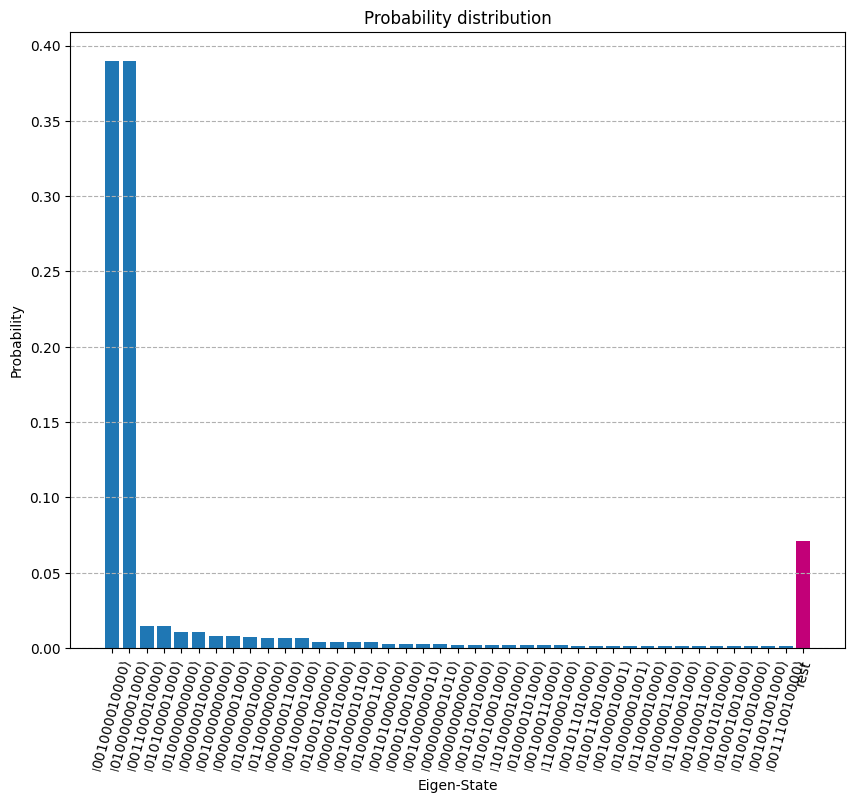

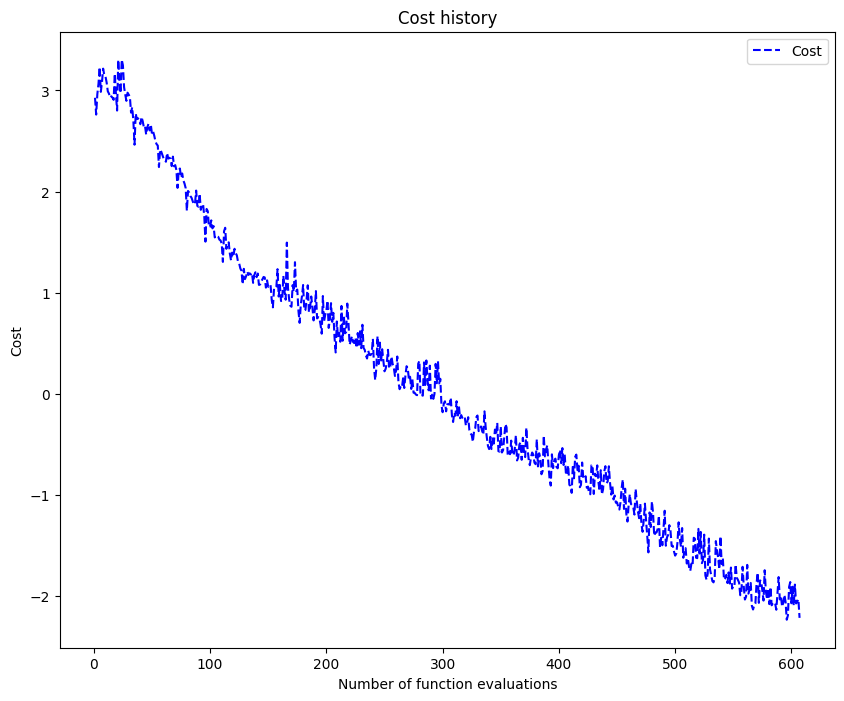

In [31]:
result = q.result
print(result.lowest_cost_bitstrings(5))
result.plot_probabilities()
result.plot_cost()


### 1.5 Discussion

As for instances 1, 2 and 4, very good results are obtained, especially considering that there is no great engineering behind the configured QAOA parameters. The parameters that most change the probability of success of the algorithm are not from the algorithm per se, but from the QUBO function. The value of the penalties and the affinity and priority weights cause an algorithm to go from a mediocre performance to a very good one and vice versa. We invite you to try and experiment with these parameters in the different instances of the problem.

As future tests, it would be interesting to detect patterns of behavior with respect to the penalties and the affinity and priority weights. If we find a way to automate the configuration of these values, we could achieve that the algorithm has a good performance regardless of the instance of the problem.

Once we have a good configuration of penalties and affinity/priority weights, the other parameter that generates a change is the number of layers of the QAOA circuit $p$. Using the QUBO configuration for each instance that comes by default in the notebook (they are the best that were found), experiment by varying the value of $p$ between 5 and 15. You will see an increase in the probability of success as $p$ increases.